In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn import metrics
from utilities import plot_confusion_matrix,plot_roc_auc,plot_classification_report,grid_search_simple,graph_result
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv("../../data/indeed.input.csv")
y = df['salaire_moyen'][pd.notnull(df['salaire_moyen'])]
X = df.drop(columns = ['salaire_min','salaire_max','salaire_moyen','3 mois renouvelable_desc','3mois renouvelable_desc'])
X = X[pd.notnull(df['salaire_moyen'])]

In [29]:
kmeans = KMeans(n_clusters=4,init = 'k-means++', max_iter=1000).fit(y.values.reshape(-1, 1))
y_class_orig = kmeans.labels_
correspondance = list(pd.DataFrame(kmeans.cluster_centers_,columns=['center']).sort_values('center').index)
y_dic = {correspondance[i]:i for i in range(len(kmeans.cluster_centers_))}
y_ord=[]
for j in y_class_orig:
    y_ord.append(y_dic[j])
y_class = np.array(y_ord)

In [ ]:
for num in range(4):
    print((y_class_orig == num).sum(),':', (y_class == y_dic[num]).sum())

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.25, random_state=0)
features = list((X_train.sum(axis = 0) != 0))
X_train = X_train.iloc[:,features]
X_test = X_test.iloc[:,features]

## Reduction des Features

### Par Random Forest

In [13]:
# Create a random forest classifier
clf_scl_ftrs = RandomForestClassifier(bootstrap=False, criterion='gini',
                max_features='log2', min_samples_split=5,
                n_estimators=50, verbose=0, warm_start=False)


# Train the classifier
clf_scl_ftrs.fit(X_train, y_train)

scl_ftrs_accuracy = []
X_important_trains = []
X_important_tests = []
features_fits = []
for thresh in list(range(60,140,1)):
#for thresh in np.arange(0.001, np.max(clf_scl_ftrs.feature_importances_), 0.01):
    try:
        sfm = SelectFromModel(clf_scl_ftrs, threshold=str(thresh/100)+'*mean')
        sfm.fit(X_train, y_train)
        X_important_train = sfm.transform(X_train)
        X_important_test = sfm.transform(X_test)
        features_fit = [X_train.columns[feature_list_index] for feature_list_index in sfm.get_support(indices=True)] 
        clf_scl_ftrs.fit(X_important_train, y_train)
        y_pred_1 = clf_scl_ftrs.predict(X_important_test)
        scl_ftrs_accuracy.append(metrics.accuracy_score(y_test, y_pred_1))
        X_important_trains.append(X_important_train)
        X_important_tests.append(X_important_test)
        features_fits.append(features_fit)
    except:
        print("Pas de colonne pour : ",thresh)
    

print("{0} best features".format(len(features_fits[np.argmax(scl_ftrs_accuracy)])))
print("accuracy : ", scl_ftrs_accuracy[np.argmax(scl_ftrs_accuracy)])
print("\n")
print(features_fits[np.argmax(scl_ftrs_accuracy)])
selected_features = features_fits[np.argmax(scl_ftrs_accuracy)]

63 best features
accuracy :  0.8261758691206544


['Lyon', 'Nantes', 'Paris', 'Toulouse', 'bac + 2', 'bac + 3', 'bac + 4', 'bac + 5', 'ingénieur', 'CDI', 'Freelance', 'Stage', 'Temps plein', 'cdi_titre', 'freelance_titre', 'stage_titre', 'cdd_desc', 'cdi_desc', 'freelance_desc', 'stage_desc', 'développeur web', 'front-end', 'asp.net', 'back end', 'c', 'c#', 'c\\+\\+', 'clean', 'css', 'e', 'excel', 'html', 'java', 'javascript', 'kotlin', 'linux', 'mongodb', 'mysql', 'nosql', 'php', 'python', 'scala', 'soap', 'sql', 'swift', 'xml', 'symfony', 'jquery', 'angular', 'react', 'git', 'github', 'visual studio', 'django', 'api rest', 'docker', 'jira', 'scrum', 'kanban', 'azure', 'aws', 'jenkins', 'centre']


In [25]:
analyse = pd.read_csv("hyperparameters/RanFor3.csv")
param = list(analyse[analyse["rank_test_score"] == 1]["params"])[0]
param

"{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 0}"

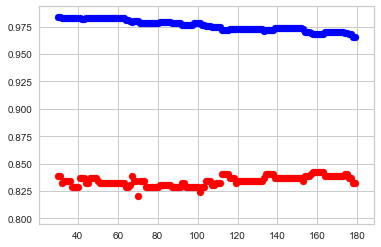

In [32]:
liste_accuracy_train = []
liste_accuracy_test = []
mean_percent = list(range(30,180,1))
for i in mean_percent:
    sel = SelectFromModel(RandomForestClassifier().set_params(**{'bootstrap': False,
                                                  'class_weight': None,
                                                  'criterion': 'gini',
                                                  'max_depth': None,
                                                  'max_features': 'sqrt',
                                                  'min_samples_split': 5,
                                                  'n_estimators': 150,
                                                  'random_state': 0}),
                          threshold = str(i/100)+'*mean')
    sel.fit(X_train, y_train)
    X_tr = sel.transform(X_train)
    X_te = sel.transform(X_test)
    rfc2 = RandomForestClassifier().set_params(**{'bootstrap': False, 'class_weight': None,
                                   'criterion': 'gini', 'max_depth': None,
                                   'max_features': 'sqrt', 'min_samples_split': 5,
                                   'n_estimators': 150, 'random_state': 0})
    rfc2.fit(X_tr, y_train)
    # Faire de nouvelles prédictions
    y_p2 = rfc2.predict(X_te)
    accuracy_test = metrics.accuracy_score(y_test,y_p2)
    accuracy_train =metrics.accuracy_score(y_train,rfc2.predict(X_tr))
    liste_accuracy_test.append(accuracy_test)
    liste_accuracy_train.append(accuracy_train)
    
plt.scatter(mean_percent,liste_accuracy_test, color = 'red')
plt.scatter(mean_percent,liste_accuracy_train, color = 'blue')

In [42]:
sel = SelectFromModel(RandomForestClassifier().set_params(**{'bootstrap': False,
                                                  'class_weight': None,
                                                  'criterion': 'gini',
                                                  'max_depth': None,
                                                  'max_features': 'sqrt',
                                                  'min_samples_split': 5,
                                                  'n_estimators': 150,
                                                  'random_state': 0}),
                          threshold = str(160/100)+'*mean')
sel.fit(X_train, y_train)
   
X_tr = sel.transform(X_train)
X_te = sel.transform(X_test)
sel.get_support()
X_train.columns[sel.get_support()]

Index(['Lyon', 'Nantes', 'Paris', 'Toulouse', 'bac + 2', 'bac + 3', 'bac + 5',
       'ingénieur', 'CDI', 'Stage', 'Temps plein', 'cdi_titre',
       'freelance_titre', 'stage_titre', 'cdd_desc', 'cdi_desc',
       'freelance_desc', 'stage_desc', 'asp.net', 'c', 'c#', 'clean', 'css',
       'e', 'excel', 'html', 'java', 'javascript', 'kotlin', 'linux',
       'mongodb', 'mysql', 'php', 'python', 'scala', 'sql', 'symfony',
       'jquery', 'angular', 'react', 'git', 'github', 'api rest', 'docker',
       'scrum', 'azure', 'aws', 'jenkins', 'centre'],
      dtype='object')

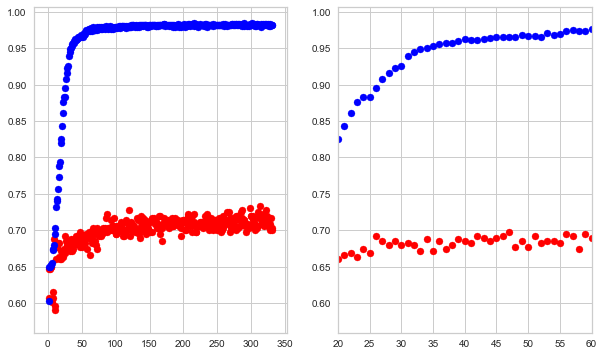

In [6]:
dic_accuracy_train = {}
dic_accuracy_test = {}
max_feat = list(range(1,X_train.shape[1]))
for i in max_feat:
    sel = SelectFromModel(RandomForestClassifier().set_params(**{'bootstrap': False,
                                                  'class_weight': None,
                                                  'criterion': 'gini',
                                                  'max_depth': None,
                                                  'max_features': 'sqrt',
                                                  'min_samples_split': 5,
                                                  'n_estimators': 150,
                                                  'random_state': 0}),
                          threshold = -np.inf, max_features = i)
    sel.fit(X_train, y_train)
    X_tr = sel.transform(X_train)
    X_te = sel.transform(X_test)
    rfc2 = RandomForestClassifier().set_params(**{'bootstrap': False, 'class_weight': None,
                                   'criterion': 'gini', 'max_depth': None,
                                   'max_features': 'sqrt', 'min_samples_split': 5,
                                   'n_estimators': 150, 'random_state': 0})
    rfc2.fit(X_tr, y_train)
    # Faire de nouvelles prédictions
    y_p2 = rfc2.predict(X_te)
    accuracy_test = metrics.accuracy_score(y_test,y_p2)
    accuracy_train =metrics.accuracy_score(y_train,rfc2.predict(X_tr))
    dic_accuracy_test[i] = (accuracy_test)
    dic_accuracy_train[i] = (accuracy_train)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)    
plt.scatter(dic_accuracy_test.keys(),dic_accuracy_test.values(), color = 'red')
plt.scatter(dic_accuracy_train.keys(),dic_accuracy_train.values(), color = 'blue')
plt.title("Test Score et Train Score \nen fonction du nombre de features",
              fontsize = 14, loc = 'center')
plt.xlabel("Nombre de features",fontsize = 12)
plt.ylabel("Score",fontsize = 12)
plt.legend(loc = 3)
plt.subplot(1,2,2)    
plt.scatter(dic_accuracy_test.keys(),dic_accuracy_test.values(), color = 'red')
plt.scatter(dic_accuracy_train.keys(),dic_accuracy_train.values(), color = 'blue')plt.title("Test Score et Train Score \nen fonction du classement au Test Score",
              fontsize = 14, loc = 'center')
plt.xlabel("Classement au Test Score",fontsize = 12)
plt.ylabel("Score",fontsize = 12)
plt.legend(loc = 3)
plt.title("Test Score et Train Score \nen fonction du nombre de features",
              fontsize = 14, loc = 'center')
    plt.xlabel("Nombre de features",fontsize = 12)
    plt.ylabel("Score",fontsize = 12)
    plt.legend(loc = 3)
plt.xlim(20,60)
plt.show()

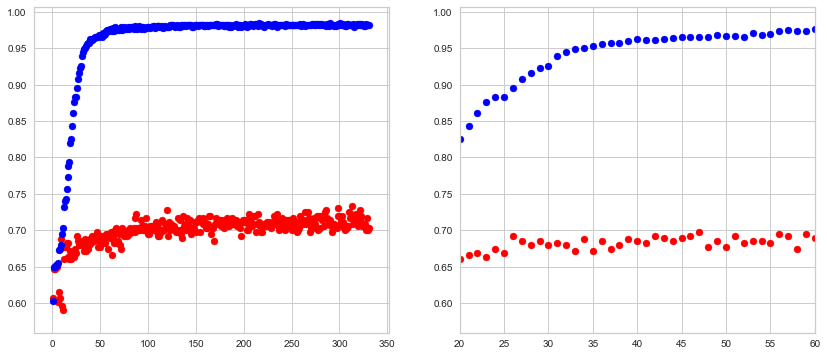

In [7]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)    
plt.scatter(dic_accuracy_test.keys(),dic_accuracy_test.values(), color = 'red')
plt.scatter(dic_accuracy_train.keys(),dic_accuracy_train.values(), color = 'blue')
plt.subplot(1,2,2)    
plt.scatter(dic_accuracy_test.keys(),dic_accuracy_test.values(), color = 'red')
plt.scatter(dic_accuracy_train.keys(),dic_accuracy_train.values(), color = 'blue')
plt.xlim(20,60)
plt.show()

In [75]:
sel = SelectFromModel(RandomForestClassifier().set_params(**{'bootstrap': False,
                                                  'class_weight': None,
                                                  'criterion': 'gini',
                                                  'max_depth': None,
                                                  'max_features': 'sqrt',
                                                  'min_samples_split': 5,
                                                  'n_estimators': 150,
                                                  'random_state': 0}),
                          threshold = -np.inf, max_features = 46)
sel.fit(X_train, y_train)
columns = list(X_train.columns[sel.get_support()])
X[columns].to_csv("hyperparameters/x_selected.csv", index = False)
y.to_csv("hyperparameters/y_selected.csv", index = False)

C:\Users\utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  del sys.path[0]


In [76]:
%%time
X = pd.read_csv("hyperparameters/x_selected.csv")
y = pd.read_csv("hyperparameters/y_selected.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.25, random_state=0)
RanFor_estimator = grid_search_simple("RanFor","RanFor_selected", X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Wall time: 13min 32s


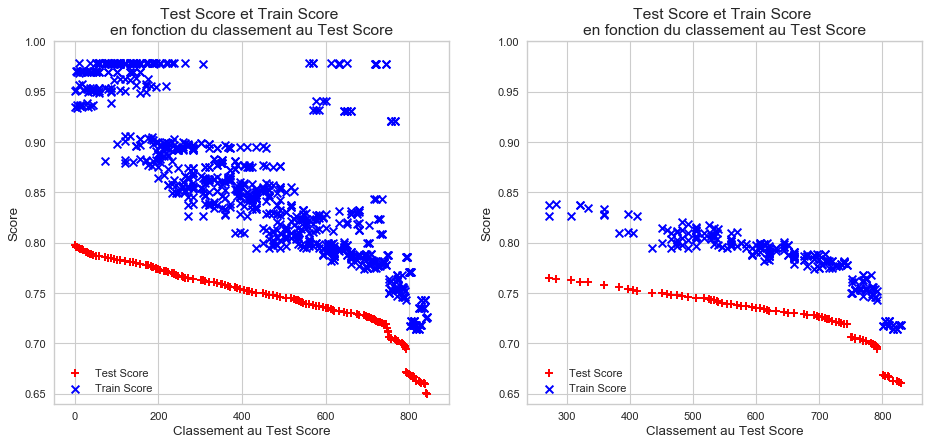

In [77]:
graph_result("RanFor_selected.csv")

In [80]:
columns

['Lyon',
 'Nantes',
 'Paris',
 'Toulouse',
 'bac + 2',
 'bac + 3',
 'bac + 4',
 'bac + 5',
 'ingénieur',
 'CDI',
 'Stage',
 'Temps plein',
 'cdi_titre',
 'freelance_titre',
 'stage_titre',
 'cdd_desc',
 'cdi_desc',
 'freelance_desc',
 'stage_desc',
 'asp.net',
 'c',
 'c#',
 'clean',
 'css',
 'e',
 'html',
 'java',
 'javascript',
 'linux',
 'mongodb',
 'mysql',
 'php',
 'python',
 'sql',
 'symfony',
 'jquery',
 'angular',
 'react',
 'git',
 'api rest',
 'docker',
 'scrum',
 'azure',
 'aws',
 'jenkins',
 'centre']

**Regression Logistique**

In [15]:
%%time
logreg_estimator = grid_search_simple("logreg","logreg_fs_randf", X_train[selected_features], y_train)

Wall time: 0 ns


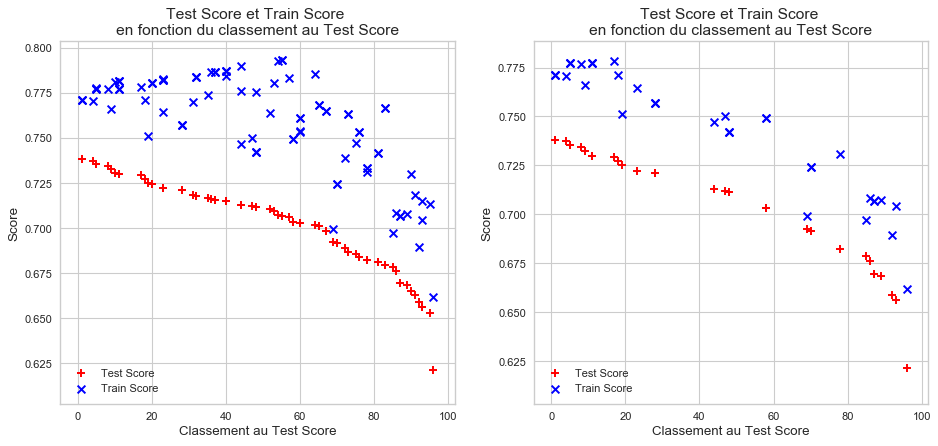

In [5]:
graph_result("logreg_fs_randf.csv")

**SVM**

In [78]:
%%time
svm_estimator = grid_search_simple("SVM","SVM_selected", X_train, y_train)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
Wall time: 11min


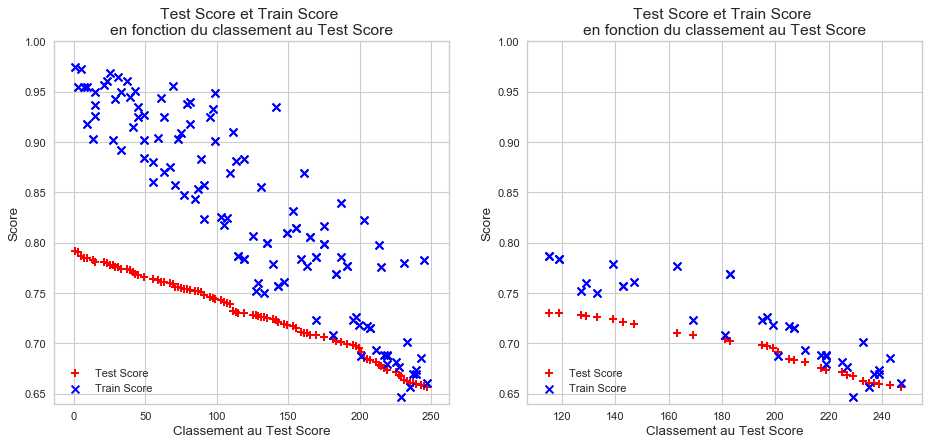

In [79]:
graph_result("SVM_selected.csv")

In [8]:
df.shape

(8015, 337)